![](https://d1.awsstatic.com/product-marketing/rds/airbnb_horizontal_lockup_web.bd87ed2c8e964eb35463744e07a1a0670177bda2.png)

# 2019 Airbnb NYC Availability Prediction

## Introduction

The data from this analysis is from [Kaggle New York City Airbnb Open Data](https://www.kaggle.com/dgomonov/new-york-city-airbnb-open-data). The dataset describes the listing activity and metrics in NYC, NY for 2019. It includes information such as the location of the listing properties, the neighbourhood of the properties, room type, price, minimum nights required, customer reviews and availability of the listing.

The purpose of this analysis is to perform exploratory data analysis as well as data visualization to understand how different factors influence the demand of the listing properties on Airbnb and ultimately using machine learning techniques to make predictions on the availability of the listing properties.

The following questions will be answered in the course of this analysis:

- Where are most of the properties listed and where is the busiest areas?
- What type of rooms are most popular?
- How are different area/neighbourhood affect the listing property price and demands?
- What are the most important factors when customer choose an airbnb property?
    - Price
    - Location
    - Room Type
    - Customer Review

## Data Loading and preprocessing

We start the analysis by importing necesssary libraries and loading the data.
The libraries used in this analysis are:

- pandas
- numpy
- matplotlib
- seaborn
- sklearn
- statsmodels

In [1]:
# Load necessary library
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')
plt.style.use('seaborn')

from wordcloud import WordCloud

%matplotlib inline

# set default plot size
plt.rcParams["figure.figsize"] = (15,8)

In [2]:
# Load and preview data 
ab_nyc = pd.read_csv("/Users/leo/Personal/GitHub/Airbnb NYC 2019 Data/AB_NYC_2019.csv")
ab_nyc.head()

id                                              name  host_id  \
0  2539                Clean & quiet apt home by the park     2787   
1  2595                             Skylit Midtown Castle     2845   
2  3647               THE VILLAGE OF HARLEM....NEW YORK !     4632   
3  3831                   Cozy Entire Floor of Brownstone     4869   
4  5022  Entire Apt: Spacious Studio/Loft by central park     7192   

     host_name neighbourhood_group neighbourhood  latitude  longitude  \
0         John            Brooklyn    Kensington  40.64749  -73.97237   
1     Jennifer           Manhattan       Midtown  40.75362  -73.98377   
2    Elisabeth           Manhattan        Harlem  40.80902  -73.94190   
3  LisaRoxanne            Brooklyn  Clinton Hill  40.68514  -73.95976   
4        Laura           Manhattan   East Harlem  40.79851  -73.94399   

         room_type  price  minimum_nights  number_of_reviews last_review  \
0     Private room    149               1                  9  2018-10-19   
1  Entire home/apt    225               1                 45  2019-05-21   
2     Private room    150               3                  0         NaN   
3  Entire home/apt     89               1                270  2019-07-05   
4  Entire home/apt     80              10                  9  2018-11-19   

   reviews_per_month  calculated_host_listings_count  availability_365  
0               0.21                               6               365  
1               0.38                               2               355  
2                NaN                               1               365  
3               4.64                               1               194  
4               0.10                               1                 0

After we load in the data, we used `describe` to get a summary statistics of the numeric data. We can see that the data need some cleanning. There are some outliers for **price** and **minimum_nights**. Other columns such as **number_of_reviews** and **calculated_host_listings_count** are highly right skewed, so that we might need to transfer them into categorical variables.

First we need to drop a few columns from the dataset that are not useful.

In [3]:
# drop id and name columns
ab_nyc.drop(['id','name','host_id','host_name'],axis=1,inplace = True)
ab_nyc.describe()

latitude     longitude         price  minimum_nights  \
count  48895.000000  48895.000000  48895.000000    48895.000000   
mean      40.728949    -73.952170    152.720687        7.029962   
std        0.054530      0.046157    240.154170       20.510550   
min       40.499790    -74.244420      0.000000        1.000000   
25%       40.690100    -73.983070     69.000000        1.000000   
50%       40.723070    -73.955680    106.000000        3.000000   
75%       40.763115    -73.936275    175.000000        5.000000   
max       40.913060    -73.712990  10000.000000     1250.000000   

       number_of_reviews  reviews_per_month  calculated_host_listings_count  \
count       48895.000000       38843.000000                    48895.000000   
mean           23.274466           1.373221                        7.143982   
std            44.550582           1.680442                       32.952519   
min             0.000000           0.010000                        1.000000   
25%             1.000000           0.190000                        1.000000   
50%             5.000000           0.720000                        1.000000   
75%            24.000000           2.020000                        2.000000   
max           629.000000          58.500000                      327.000000   

       availability_365  
count      48895.000000  
mean         112.781327  
std          131.622289  
min            0.000000  
25%            0.000000  
50%           45.000000  
75%          227.000000  
max          365.000000

Then we check na for each column, most of the columns doesn't have na other than the **last_review** and **reviews_per_month** for those listing properties doesn't have any reviews.

In [4]:
# Check each column for nas
ab_nyc.isnull().sum()

neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       10052
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

Then we want to remove the outliers for **price** and **minimum_nights** column. we calculate z score for both column and remove all records that have a z score greater than 3.

For the columns that are highly skewed, for example **number_of_reviews** and **calculated_host_listings_count**, we transfer them into categorical variable. Based on the summary statistics, we can see that the first 25 percentile of **minimum_nights** are 1, the median is 3 and the 75% percentile is 5, an reasonable categorization would be one night, two nights, three nights, four nights and five nights or more. Then we check we have enough and evenly distributed values in each of the group using `groupby()` and `size()`.

We'll do the same for **calculated_host_listings_count** and transfer the column into one listing, two listing and more than two listing.

In [5]:
# data cleanning
# remove outliers for price and minimun nights column

from scipy import stats

ab_nyc['z_price'] = np.abs(stats.zscore(ab_nyc['price']))
ab_nyc['z_min_nights'] = np.abs(stats.zscore(ab_nyc['minimum_nights']))

# remove z scroe that are greater than 3

ab_nyc_final = ab_nyc[(ab_nyc['z_price'] < 3)]
ab_nyc_final = ab_nyc_final[(ab_nyc_final['price'] > 3)]
ab_nyc_final = ab_nyc_final[(ab_nyc['z_min_nights'] < 3)]

# convert numneric variables into categorical variables

ab_nyc_final['minimum_nights_group'] = 'Others'
ab_nyc_final['minimum_nights_group'][ab_nyc_final['minimum_nights'] == 1] = 'one night'
ab_nyc_final['minimum_nights_group'][ab_nyc_final['minimum_nights'] == 2] = 'two nights'
ab_nyc_final['minimum_nights_group'][ab_nyc_final['minimum_nights'] == 3] = 'three nights'
ab_nyc_final['minimum_nights_group'][ab_nyc_final['minimum_nights'] == 4] = 'four nights'
ab_nyc_final['minimum_nights_group'][ab_nyc_final['minimum_nights'] > 4] = 'five nights or more'
# ab_nyc_final.groupby('minimum_nights_group').size()

ab_nyc_final['calculated_host_listings_count_group'] = 'Others'
ab_nyc_final['calculated_host_listings_count_group'][ab_nyc_final['calculated_host_listings_count'] == 1] = 'one listing'
ab_nyc_final['calculated_host_listings_count_group'][ab_nyc_final['calculated_host_listings_count'] == 2] = 'two listings'
ab_nyc_final['calculated_host_listings_count_group'][ab_nyc_final['calculated_host_listings_count'] > 2] = 'more than two listings'


# ab_nyc_final.groupby('calculated_host_listings_count_group').size()


Clean the dataset by removing intermediate columns, we get the final data for exploratory data analysis and visualization.

In [6]:
# remove unused columns
ab_nyc_final.drop(['z_price','z_min_nights','minimum_nights','last_review','neighbourhood',
                   'calculated_host_listings_count','reviews_per_month'],
                  axis = 1,inplace = True)
ab_nyc_final.head()

neighbourhood_group  latitude  longitude        room_type  price  \
0            Brooklyn  40.64749  -73.97237     Private room    149   
1           Manhattan  40.75362  -73.98377  Entire home/apt    225   
2           Manhattan  40.80902  -73.94190     Private room    150   
3            Brooklyn  40.68514  -73.95976  Entire home/apt     89   
4           Manhattan  40.79851  -73.94399  Entire home/apt     80   

   number_of_reviews  availability_365 minimum_nights_group  \
0                  9               365            one night   
1                 45               355            one night   
2                  0               365         three nights   
3                270               194            one night   
4                  9                 0  five nights or more   

  calculated_host_listings_count_group  
0               more than two listings  
1                         two listings  
2                          one listing  
3                          one listing  
4                          one listing

In [7]:
ab_nyc_final.describe()

latitude     longitude         price  number_of_reviews  \
count  48186.000000  48186.000000  48186.000000       48186.000000   
mean      40.728860    -73.951902    138.780932          23.476570   
std        0.054605      0.046211    107.583370          44.736442   
min       40.499790    -74.244420     10.000000           0.000000   
25%       40.689930    -73.982830     69.000000           1.000000   
50%       40.722900    -73.955490    105.000000           5.000000   
75%       40.763130    -73.935922    175.000000          24.000000   
max       40.913060    -73.712990    860.000000         629.000000   

       availability_365  
count      48186.000000  
mean         111.654505  
std          131.070387  
min            0.000000  
25%            0.000000  
50%           43.000000  
75%          223.000000  
max          365.000000

## Data Visualization

For data visualization, we start with plotting a correlation matrix to explore the correlation between each numeric variable using `corr()` function. then we plot it using seaborn heatmap.

In [8]:
ab_nyc_cor = ab_nyc_final.drop(['latitude','longitude'],axis=1).corr()
ab_nyc_cor

price  number_of_reviews  availability_365
price              1.000000          -0.056260          0.113544
number_of_reviews -0.056260           1.000000          0.177244
availability_365   0.113544           0.177244          1.000000

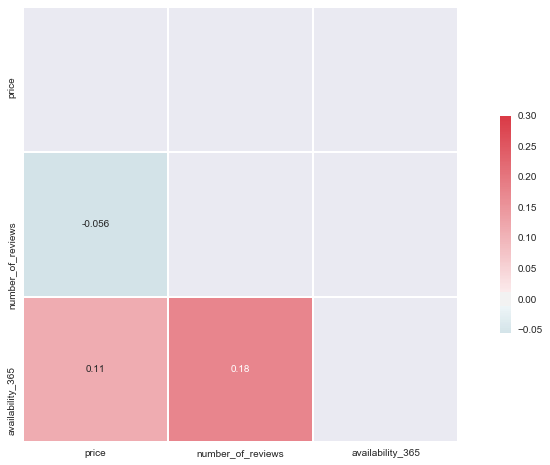

In [9]:
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(ab_nyc_cor, dtype=np.bool))

# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(15, 8))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(ab_nyc_cor, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5},annot = True)

From the plot, we can see that there's no strong correlation between each numeric variables. No correlation coefficient greater than 0.7.

Then we want to plot all the listing properties on the map to see where the most properties located and how their price differs.

For this task, we used `plotly` and `density_mapbox` by passing latitude, longitude and price.

From the plot, we can see that as expected, most properties are in Manhattan, on the south side of the Central Park, and also on the north side of Brooklyn around Willamsburg Bridge. These location offers the most convenient transportation for the tourists in that they are either in Manhattan or near it. By looking at the price, these locations also have the highest prices.

In [10]:
import plotly.express as px

lat = np.mean(ab_nyc_final['latitude'])
lon = np.mean(ab_nyc_final['longitude'])


fig = px.density_mapbox(ab_nyc_final, lat='latitude', lon='longitude', z='price', radius=2,
                        center=dict(lat = lat, lon = lon), zoom=10,
                        mapbox_style="carto-positron")
fig.show()

To further explore how location affect listing properties, the following code calculate the mean and median for **price**, **number_of_reviews** and **availability_365**.

We can see that Manhattan has the most listing and the highest median price, followed by Brooklyn. However, Brooklyn have a higher demand than Manhattan as the **availability_365** mean and median is the lowest.

In [11]:
ab_nyc_final.groupby(['neighbourhood_group'])['price','number_of_reviews','availability_365'].agg(['count', 'mean','median'])

# ab_nyc_final.groupby(['neighbourhood_group']).agg({
#     'price': ['mean', 'count', 'median'], 
#     'number_of_reviews': ['mean', 'count', 'median'],
#     'availability_365': ['mean', 'count', 'median']
# })

price                    number_of_reviews             \
                     count        mean median             count       mean   
neighbourhood_group                                                          
Bronx                 1076   84.697955     65              1076  26.267658   
Brooklyn             19906  116.557420     90             19906  24.307144   
Manhattan            21200  175.004528    149             21200  21.270519   
Queens                5635   94.125998     75              5635  27.798403   
Staten Island          369   96.138211     75               369  31.276423   

                           availability_365                     
                    median            count        mean median  
neighbourhood_group                                             
Bronx                    9             1076  165.349442  147.5  
Brooklyn                 6            19906   99.542399   27.0  
Manhattan                4            21200  110.192547   34.0  
Queens                   7             5635  143.973026   97.0  
Staten Island           12              369  198.934959  216.0

Then we will use `boxplot` to visualize the median by different categorical variables to explore how the price and availabilty differ between groups

*Boxplot of neighbourhood group and room type with price*

- Entire home/apt have the highest median price over other room types, followed by Private room and shared room, as expected
- Manhattan entire home/apt have the highest median price, followed by Brooklyn


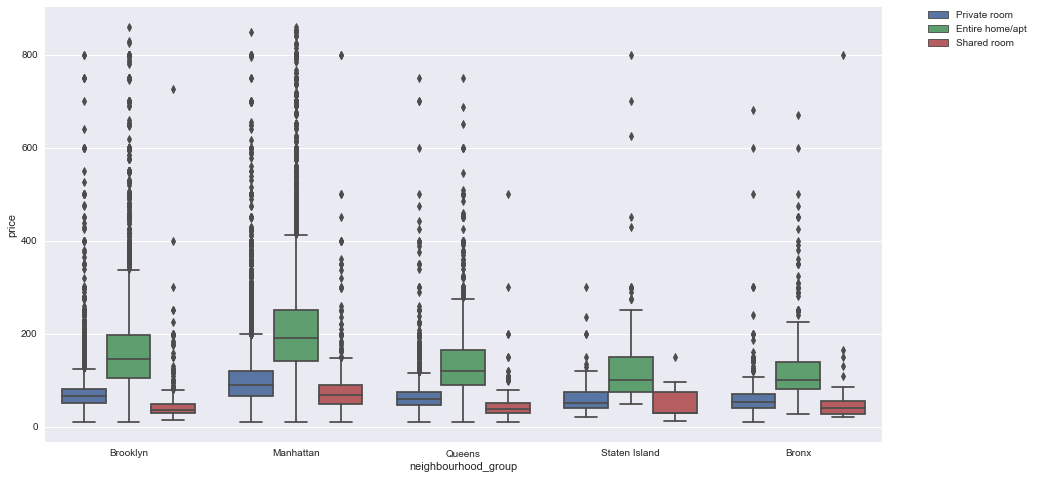

In [12]:
# boxplot of neighbourhood group and price
# entire home/apt have the highest median price over other room types
# manhattan entire home/apt have the highest median price
sns.boxplot(x="neighbourhood_group", y="price",hue = "room_type",data=ab_nyc_final)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

*Boxplot of neighbourhood group and room type with availability*

- Brooklyn entire home/apt have the lowest availability/highest demand, followed by Manhattan's entire home/apt
- Staten Island properties have the lowest demand
- The most popular/high demand room type is private room and entire home/apt in most locations other than Staten Island and Bronx

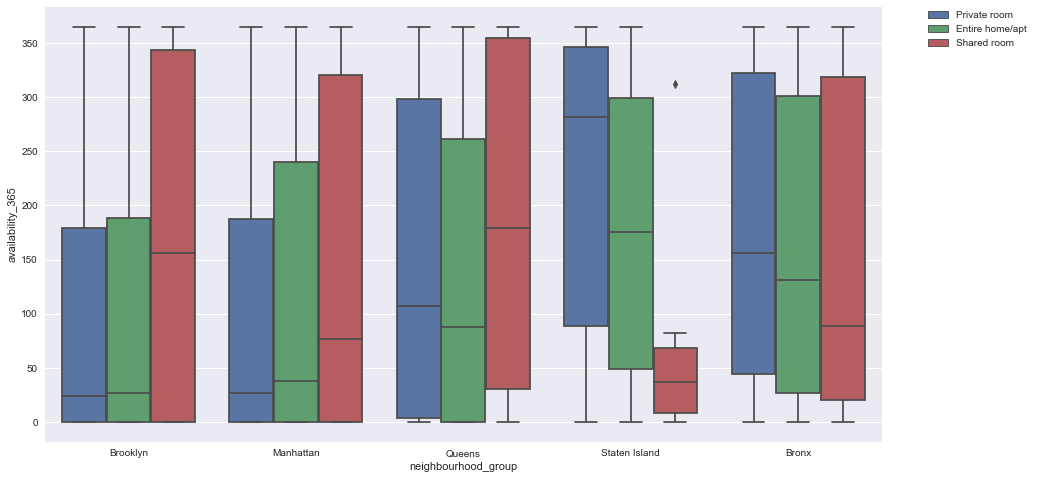

In [13]:
# manhattan and brooklyn private room have the lowest availability/highest demand overall
sns.boxplot(x="neighbourhood_group", y="availability_365",hue = "room_type",data=ab_nyc_final)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

*Boxplot of minimum nights group with availability*

Four nights minimum are the most popular overall.

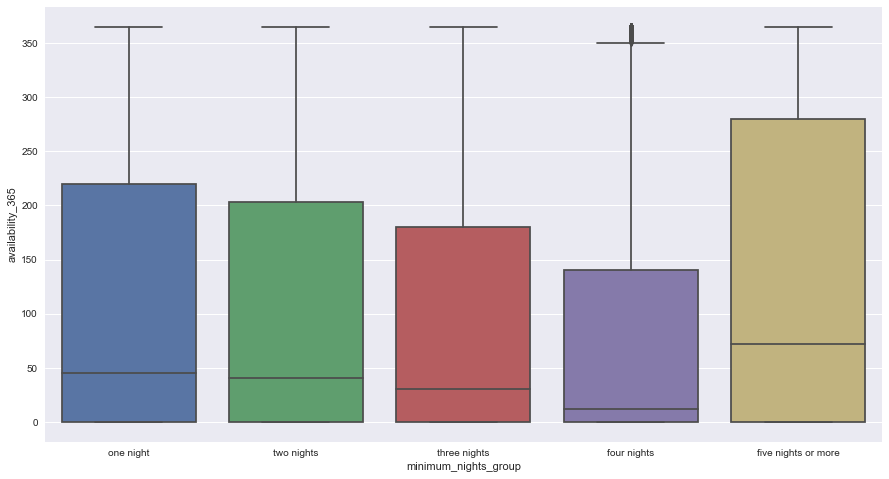

In [14]:
# four nights minimum are the most popular
sns.boxplot(x="minimum_nights_group", y="availability_365",data=ab_nyc_final,
            order = ['one night','two nights','three nights','four nights','five nights or more'])

*Boxplot of minimum nights group with price*

One nights minimum is the most cheapest overall.

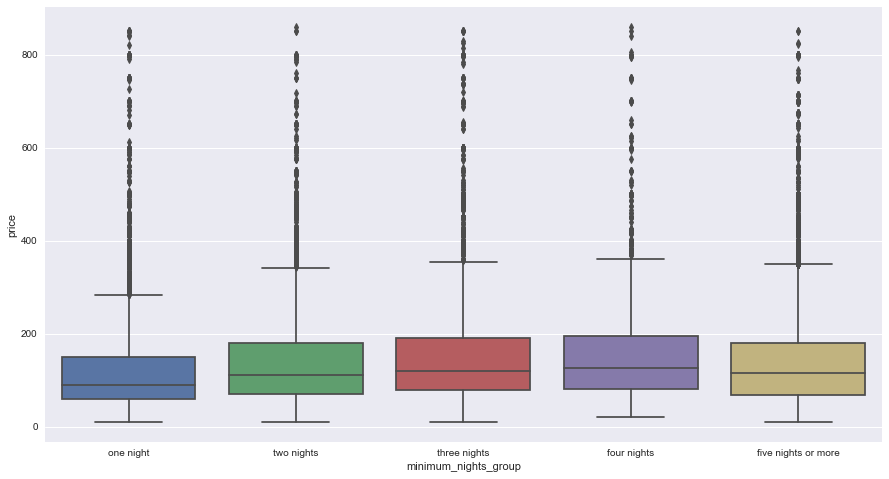

In [15]:
sns.boxplot(x="minimum_nights_group", y="price",data=ab_nyc_final,
            order = ['one night','two nights','three nights','four nights','five nights or more'])

The last visualization we will use `pairplot` in seaborn to explore the distribution and correlation of all numeric variables. As we seen earlier, there's no strong linear correlation between each individual variable. However, we can see that there might be some non-linear correlation between price/number of review.

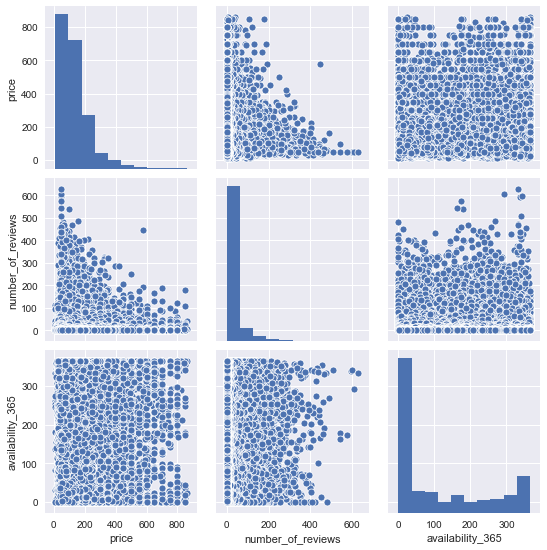

In [16]:
sns.pairplot(ab_nyc_final.drop(['latitude','longitude'],axis=1))

## Model Building

The ultimate goal of this analysis is to predict the availability of a listing property based on its location, price and other metrics. We will try different regression to fit the data and find out which model best fit the data and make the most accurate prediction.

### Multiple Linear Regression

The first regression method used is multiple linear regression.

Before fitting the model, we need to transfer the categorical variables into binary using **one hot encoding**.

In [17]:
ab_nyc_model = ab_nyc_final.drop(['latitude','longitude'],axis = 1)
ab_nyc_model.head()

neighbourhood_group        room_type  price  number_of_reviews  \
0            Brooklyn     Private room    149                  9   
1           Manhattan  Entire home/apt    225                 45   
2           Manhattan     Private room    150                  0   
3            Brooklyn  Entire home/apt     89                270   
4           Manhattan  Entire home/apt     80                  9   

   availability_365 minimum_nights_group calculated_host_listings_count_group  
0               365            one night               more than two listings  
1               355            one night                         two listings  
2               365         three nights                          one listing  
3               194            one night                          one listing  
4                 0  five nights or more                          one listing

In [18]:
# Building the model
# first convert categorical variables to dummy variables using one hot encoding

categorical_var = ['neighbourhood_group','room_type','minimum_nights_group','calculated_host_listings_count_group']

# create dummy variables for all the other categorical variables

for variable in categorical_var:
# #     fill missing data
#     recruit[variable].fillna('Missing',inplace=True)
#     create dummy variables for given columns
    dummies = pd.get_dummies(ab_nyc_model[variable],prefix=variable)
#     update data and drop original columns
    ab_nyc_model = pd.concat([ab_nyc_model,dummies],axis=1)
    ab_nyc_model.drop([variable],axis=1,inplace=True)

ab_nyc_model.head()

price  number_of_reviews  availability_365  neighbourhood_group_Bronx  \
0    149                  9               365                          0   
1    225                 45               355                          0   
2    150                  0               365                          0   
3     89                270               194                          0   
4     80                  9                 0                          0   

   neighbourhood_group_Brooklyn  neighbourhood_group_Manhattan  \
0                             1                              0   
1                             0                              1   
2                             0                              1   
3                             1                              0   
4                             0                              1   

   neighbourhood_group_Queens  neighbourhood_group_Staten Island  \
0                           0                                  0   
1                           0                                  0   
2                           0                                  0   
3                           0                                  0   
4                           0                                  0   

   room_type_Entire home/apt  room_type_Private room  room_type_Shared room  \
0                          0                       1                      0   
1                          1                       0                      0   
2                          0                       1                      0   
3                          1                       0                      0   
4                          1                       0                      0   

   minimum_nights_group_five nights or more  minimum_nights_group_four nights  \
0                                         0                                 0   
1                                         0                                 0   
2                                         0                                 0   
3                                         0                                 0   
4                                         1                                 0   

   minimum_nights_group_one night  minimum_nights_group_three nights  \
0                               1                                  0   
1                               1                                  0   
2                               0                                  1   
3                               1                                  0   
4                               0                                  0   

   minimum_nights_group_two nights  \
0                                0   
1                                0   
2                                0   
3                                0   
4                                0   

   calculated_host_listings_count_group_more than two listings  \
0                                                  1             
1                                                  0             
2                                                  0             
3                                                  0             
4                                                  0             

   calculated_host_listings_count_group_one listing  \
0                                                 0   
1                                                 0   
2                                                 1   
3                                                 1   
4                                                 1   

   calculated_host_listings_count_group_two listings  
0                                                  0  
1                                                  1  
2                                                  0  
3                                                  0  
4                                                  0

This will be our final dataset to fit the model.

Then we split the dataset into training and testing dataset with 70/30 split. We'll use the regression module in both `statsmodels` and `sklearn`

In [19]:
x = ab_nyc_model.drop(['availability_365'], axis=1)
y = ab_nyc_model['availability_365'].astype(float)

# split train and test dataset
train_x, test_x, train_y, test_y = train_test_split(x,y , test_size=0.3, random_state=42)

print(train_x.shape)
print(train_y.shape)

print(test_x.shape)
print(test_y.shape)

(33730, 18)
(33730,)
(14456, 18)
(14456,)


#### Multiple Linear Regression using Statsmodels

After fitting the model, we can see that the R square is 0.23, which is not very high, given that all of the variables are significant with a p value less than 0.05.

Looking at the coefficients, we can see that both price and number_of_review is positive, which means the higher both these two are, the least demand for the listing property will be. Manhattan and Brooklyn have a negative coefficient, which means properties in these two locations have a higher demand. Additionally, entire roo,/apt is the most popular room type.

In [20]:
# training using statmodel

linear_model_sm = sm.OLS(train_y,sm.tools.add_constant(train_x).astype(float))
results_sm = linear_model_sm.fit()
print(results_sm.summary())

                            OLS Regression Results                            
Dep. Variable:       availability_365   R-squared:                       0.236
Model:                            OLS   Adj. R-squared:                  0.235
Method:                 Least Squares   F-statistic:                     742.6
Date:                Sun, 02 Aug 2020   Prob (F-statistic):               0.00
Time:                        16:03:11   Log-Likelihood:            -2.0772e+05
No. Observations:               33730   AIC:                         4.155e+05
Df Residuals:                   33715   BIC:                         4.156e+05
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                                                                  coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------

#### Multiple Linear Regression using Sklearn

Then we fit the regression using Sklearn, the result is similar with a low model score of 0.23. this suggest that maybe the data doesn't fit a linear relationship because the prediction have a high variance from the actual value. We may need to try to use other non-linear regression techniques.

In [21]:
# using sklearn

linear_model_sk = LinearRegression()  
linear_model_sk.fit(train_x, train_y)
linear_model_sk.score(test_x, test_y)

0.23011788668930258

In [22]:
pred_y = linear_model_sk.predict(test_x)
df = pd.DataFrame({'Actual': test_y, 'Predicted': pred_y})
df.head(30)

Actual   Predicted
1601     89.0  167.150534
6870    261.0   62.741728
15886     0.0   41.338514
2802    274.0  110.620696
9874      0.0  120.986227
28059    66.0   50.805914
37492     0.0  125.018665
39289     7.0   25.261000
7840      0.0   76.592202
22632   120.0   69.809637
41533    89.0   51.813738
15473     0.0   49.321177
35612   258.0   75.320635
47521    37.0   39.167109
18578     0.0  119.100418
45330    14.0   52.649877
6925    168.0  112.917342
35149    28.0  186.052548
2259    284.0  204.182491
19931    26.0  103.288850
3819    112.0  143.916014
17634    24.0   87.058245
42622    73.0   78.400153
30721    38.0  170.916732
40163   269.0  230.598216
36977   305.0  316.050901
42525     0.0   92.653195
43277     0.0   43.271592
13697     0.0   36.746686
13684     0.0   47.121637

### Random Forest Regressor

Random forest is a popular machine learning techniques that can not only be used in classification problems, but also be used in regression problems. To make random forest uniques is that it can also be used to fit non-linear relationship.

#### Initial Model

We first start an instance of the model with a randomly chosen parameters. These prameters will later be tuned to yield optimized results.

In [23]:
# random forest regressor for non-linear regression

rf_regressor = RandomForestRegressor(n_estimators=100,random_state=0)
rf_regressor.fit(train_x,train_y)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=0, verbose=0, warm_start=False)

The random forest has a score of 0.77, which is significantly higher than linear regression.

In [24]:
rf_regressor.score(train_x,train_y)

0.7789341315426832

To see which feature have the most influence, the bar plot below plots each features from the most significant to the least.

We can see that the **price** and **number_of_review** have the most influence on availability of the listing.

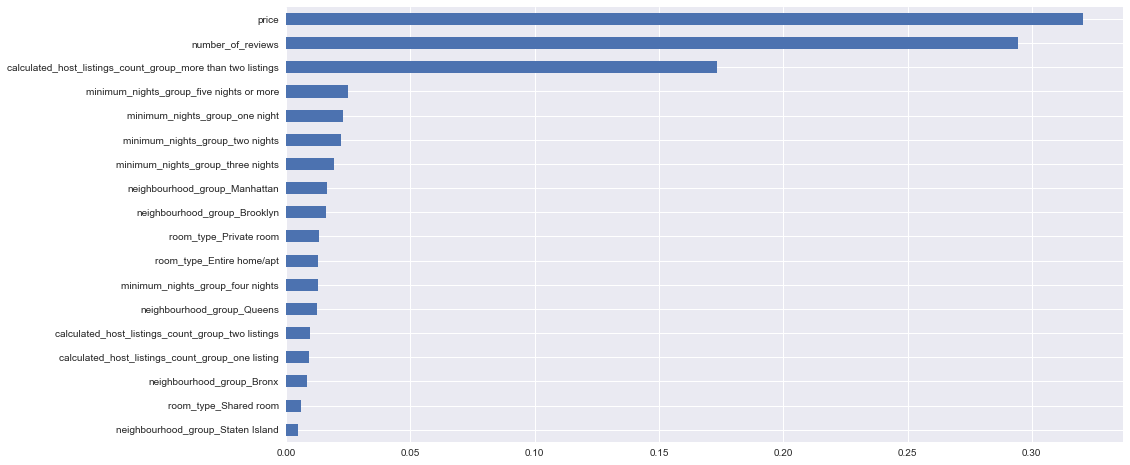

In [25]:
feature_importance = pd.Series(rf_regressor.feature_importances_,index=x.columns)
feature_importance = feature_importance.sort_values()
feature_importance.plot(kind='barh')

#### Parameter Tuning

We want to tune the parameter for the random forest regressor to optimize the results.

##### n_estimator_options tunning

We will choose 500 trees based on the plot because after 500 trees, the model score increase is flattened.

30  trees
0.771710002034736

50  trees
0.7758604919470872

100  trees
0.7788593407746083

200  trees
0.7807896723707708

500  trees
0.7818760058095218

1000  trees
0.7821850310401464

2000  trees
0.7823330567609043



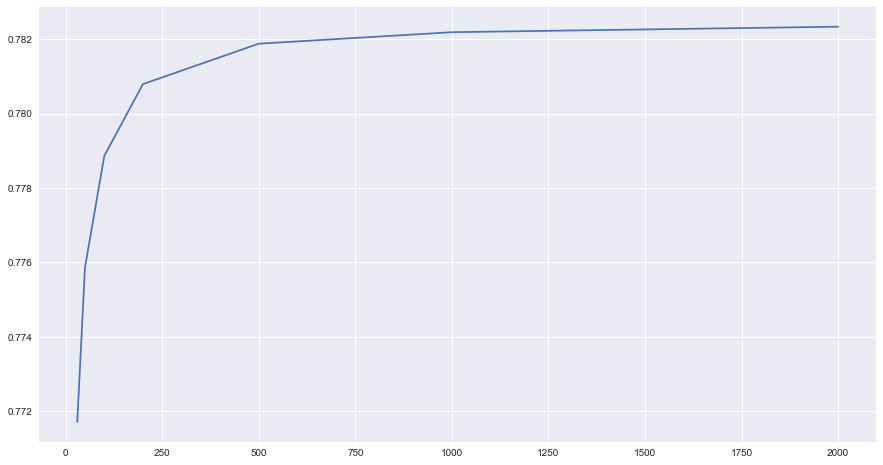

In [26]:
# parameter tunning
# # of trees trained parameter tunning

results_rf = []
n_estimator_options = [30,50,100,200,500,1000,2000]

for trees in n_estimator_options:
    model = RandomForestRegressor(trees,oob_score=True,n_jobs=-1,random_state=42)
    model.fit(train_x,train_y)
    print(trees," trees")
    score = model.score(train_x,train_y)
    print(score)
    results_rf.append(score)
    print("")

pd.Series(results_rf,n_estimator_options).plot()

# use 500 trees

##### max_features_options tunning

We will choose auto option.

auto  option
0.7818760058095218

None  option
0.7818760058095218

sqrt  option
0.7802853705753993

log2  option
0.7802853705753993

0.9  option
0.7821012077766095

0.2  option
0.7800829205172464



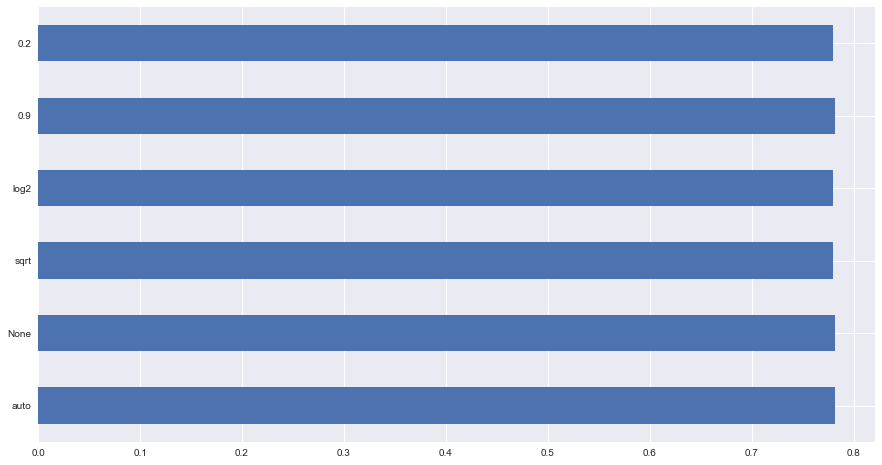

In [27]:
# max number of features parameter tunning
results_rf = []
max_features_options = ['auto',None,'sqrt','log2',0.9,0.2]

for max_features in max_features_options:
    model = RandomForestRegressor(n_estimators=500,oob_score=True,n_jobs=-1,
                                  random_state=42,max_features=max_features)
    model.fit(train_x,train_y)
    print(max_features," option")
    score = model.score(train_x,train_y)
    print(score)
    results_rf.append(score)
    print("")

pd.Series(results_rf,max_features_options).plot(kind='barh')

# use auto option

#### Final Model

Based on the parameter tunning, we will use `n_estimators=500` and `max_features='auto'` to fit the random forest regressor. The final model has a score of 0.78 

In [28]:
# final model using the parameter tuning
rf_regressor = RandomForestRegressor(n_estimators=500,oob_score=True,n_jobs=-1,
                                  random_state=42,max_features='auto')
rf_regressor.fit(train_x,train_y)
rf_regressor.score(train_x,train_y)

0.7818760058095218

#### Model Prediction

The following output shows the actual and the predicted value.

In [29]:
pred_y = rf_regressor.predict(test_x)
df = pd.DataFrame({'Actual': test_y, 'Predicted': pred_y})
df.head(30)

Actual   Predicted
1601     89.0  147.490000
6870    261.0  134.278000
15886     0.0    9.798800
2802    274.0  155.573900
9874      0.0  126.658200
28059    66.0   39.970000
37492     0.0  136.669952
39289     7.0   27.044528
7840      0.0  109.421067
22632   120.0   19.872000
41533    89.0   22.339000
15473     0.0    0.911876
35612   258.0  145.415733
47521    37.0    0.797333
18578     0.0  154.988000
45330    14.0   32.464395
6925    168.0  117.804000
35149    28.0  176.265500
2259    284.0  175.302000
19931    26.0  119.826476
3819    112.0  187.670000
17634    24.0  179.948586
42622    73.0   62.623043
30721    38.0  109.445767
40163   269.0  170.212281
36977   305.0  260.441313
42525     0.0   96.560329
43277     0.0    0.000000
13697     0.0    0.434667
13684     0.0   14.301300

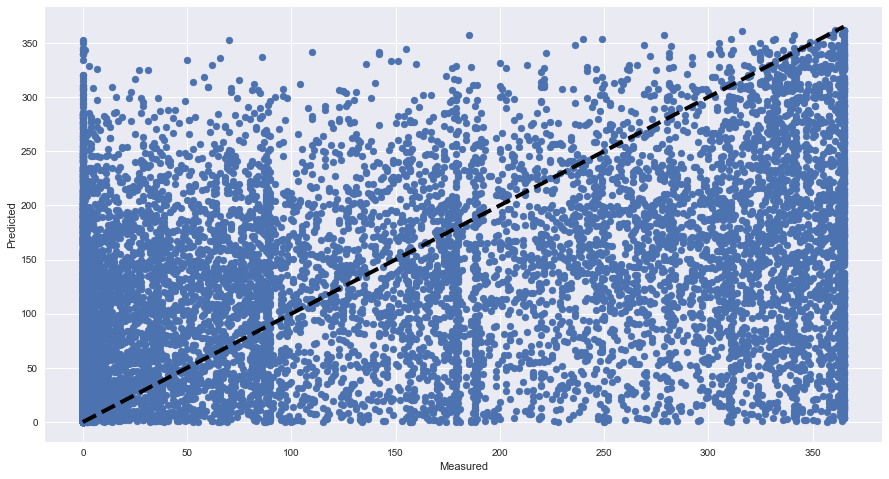

In [30]:
fig, ax = plt.subplots()
ax.scatter(test_y, pred_y)
ax.plot([test_y.min(), test_y.max()], [test_y.min(), test_y.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

## Conclusion

Through this analysis, we have a better idea on the key factors that influences the demand of an airbnb listing property. Tourists/customers prefer location close to downtown, lower price and entire room which offers them more privacy when touring the city. These can all be taken into consideration for airbnb hosts when posting their properties online.
